In [34]:
import os
import time
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import resnet18, mobilenet
from PIL import Image

from IPython.display import clear_output
%matplotlib inline

from sklearn.model_selection import train_test_split

sns.set(font_scale=1.2)
sns.set_style(style='dark')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')
print(f'Версия pytorch: {torch.__version__}')

Устройство: cuda
Версия pytorch: 2.3.0.dev20240105+cu121


In [35]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self = nn.Sequential()
        self.add_module('mobilenet', mobilenet.mobilenet_v3_large(pretrained=False))
        self.add_module('relu_1', nn.ReLU())
        self.add_module('fc_1', nn.Linear(1000, 512))
        self.add_module('relu_2', nn.ReLU())
        self.add_module('fc_2', nn.Linear(512, 42))
        # self.to(device)
        
    def forward(self, x):
        x = torch.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [43]:
path_to_dir = './dataset/simpsons_dataset'

folders = []
for folder_name in os.listdir(path_to_dir):
    if os.path.isdir(os.path.join(path_to_dir, folder_name)):
        print(len(folders), folder_name)
        folders.append(folder_name)

0 abraham_grampa_simpson
1 agnes_skinner
2 apu_nahasapeemapetilon
3 barney_gumble
4 bart_simpson
5 carl_carlson
6 charles_montgomery_burns
7 chief_wiggum
8 cletus_spuckler
9 comic_book_guy
10 disco_stu
11 edna_krabappel
12 fat_tony
13 gil
14 groundskeeper_willie
15 homer_simpson
16 kent_brockman
17 krusty_the_clown
18 lenny_leonard
19 lionel_hutz
20 lisa_simpson
21 maggie_simpson
22 marge_simpson
23 martin_prince
24 mayor_quimby
25 milhouse_van_houten
26 miss_hoover
27 moe_szyslak
28 ned_flanders
29 nelson_muntz
30 otto_mann
31 patty_bouvier
32 principal_skinner
33 professor_john_frink
34 rainier_wolfcastle
35 ralph_wiggum
36 selma_bouvier
37 sideshow_bob
38 sideshow_mel
39 snake_jailbird
40 troy_mcclure
41 waylon_smithers


['./dataset/simpsons_dataset\\homer_simpson\\pic_1221.jpg', './dataset/simpsons_dataset\\ned_flanders\\pic_1306.jpg', './dataset/simpsons_dataset\\bart_simpson\\pic_0205.jpg', './dataset/simpsons_dataset\\groundskeeper_willie\\pic_0046.jpg', './dataset/simpsons_dataset\\chief_wiggum\\pic_0927.jpg', './dataset/simpsons_dataset\\waylon_smithers\\pic_0175.jpg', './dataset/simpsons_dataset\\abraham_grampa_simpson\\pic_0212.jpg', './dataset/simpsons_dataset\\krusty_the_clown\\pic_1116.jpg', './dataset/simpsons_dataset\\troy_mcclure\\pic_0002.jpg', './dataset/simpsons_dataset\\waylon_smithers\\pic_0171.jpg']


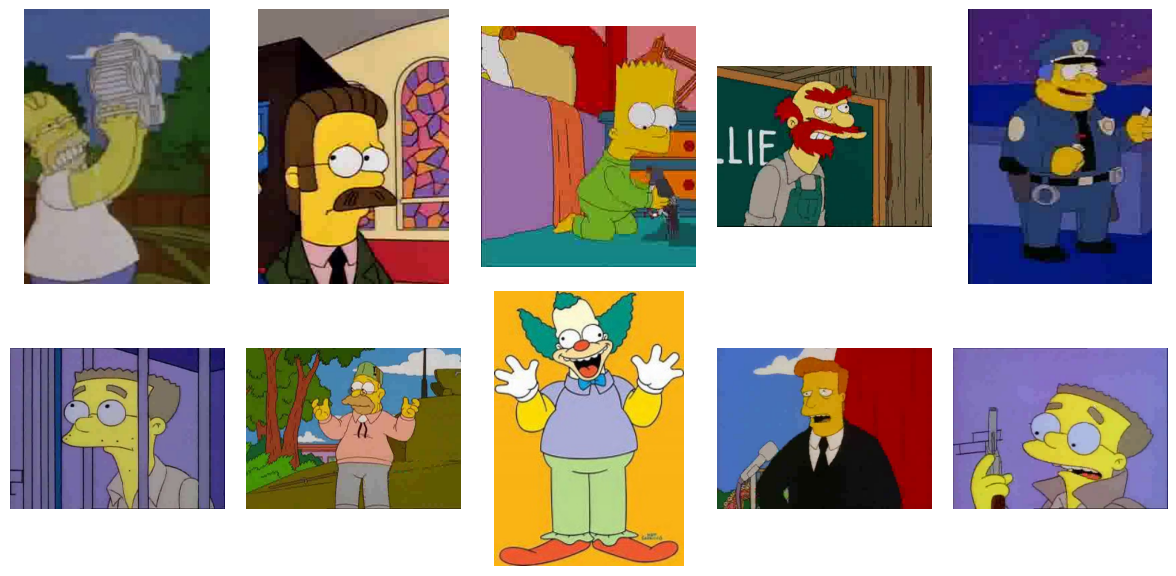

In [57]:
import random

path_to_dir = './dataset/simpsons_dataset'

# Получение списка папок
folders = [folder_name for folder_name in os.listdir(path_to_dir) if os.path.isdir(os.path.join(path_to_dir, folder_name))]

file_paths = []
for i in range(10):
    random_folder = random.choice(folders)
    folder_path = os.path.join(path_to_dir, random_folder)
    files = [file_name for file_name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_name))]
    random_file = random.sample(files, 1)
    file_paths.append(os.path.join(folder_path, random_file[0]))

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.flatten()
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
print(file_paths)
tensors = []
for i, file_path in enumerate(file_paths):
    image = Image.open(file_path)
    tensor = transform(image)
    tensors.append(tensor)

    # Отображение изображения
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [58]:
input_size = 224
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor()
])
image_path = './dataset/kaggle_simpson_testset/lisa_simpson/pic_0000.jpg'
image = Image.open(image_path)
input_data = transform(image)
input_data = input_data.unsqueeze(0)

# model = MyModel()
weights_path = './weights/fine_tuning_weights_finetuning_cosinerLR'
# model.load_state_dict(torch.load(weights_path))
# model.eval()

fine_tuning_mobilenet = nn.Sequential()

fine_tuning_mobilenet.add_module('mobilenet', mobilenet.mobilenet_v3_large(pretrained=False))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_mobilenet.add_module('relu_1', nn.ReLU())
fine_tuning_mobilenet.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_mobilenet.add_module('relu_2', nn.ReLU())
fine_tuning_mobilenet.add_module('fc_2', nn.Linear(512, 42))
fine_tuning_mobilenet.load_state_dict(torch.load(weights_path, map_location=torch.device("cpu")))
fine_tuning_mobilenet.eval()
# fine_tuning_mobilenet = fine_tuning_mobilenet.to(device)

for tensor in tensors:
    output = fine_tuning_mobilenet(tensor.unsqueeze(0))
    # Получение индекса класса с наибольшей вероятностью
    predicted_class = torch.argmax(output)
    print(folders[predicted_class])

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


homer_simpson
ned_flanders
bart_simpson
groundskeeper_willie
chief_wiggum
waylon_smithers
abraham_grampa_simpson
krusty_the_clown
troy_mcclure
waylon_smithers
